# Identify generic genes and pathways

This notebook performs the following steps to identify generic genes
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.

3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic

**Evaluation:**
We want to compare our ranking using ponyo, compared to the ranking found from Crow et. al.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import calc, process

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_compendium_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']
col_to_rank = params['col_to_rank']
compare_genes = params['compare_genes']
statistic = params['gsea_statistic']

gene_summary_file = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}.tsv")

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

# Load metadata file with grouping assignments for samples
sample_id_metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv")

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))

### Simulate experiments using selected template experiment

In [4]:
# Simulate multiple experiments
for i in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        i)

Instructions for updating:
Colocations handled automatically by placer.


Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](../explore_data/0_explore_input_data.ipynb)

In [5]:
if os.path.exists(sample_id_metadata_file):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_file, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)

    process.subset_samples(sample_ids_to_drop,
                           num_runs,
                           local_dir,
                           project_id)

### Differential expression analysis

In [6]:
# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [7]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")

NULL


In [8]:
%%R
library('limma')

In [9]:
# Check ordering of sample ids is consistent between gene expression data and metadata
process.check_sample_ordering(template_data_file, metadata_file)

sample ids are ordered correctly


In [10]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../generic_expression_patterns_modules/DE_analysis.R')

get_DE_stats(metadata_file,
             project_id, 
             template_data_file,
             "template",
             local_dir,
             "real")

[1] 2361


In [11]:
# Check ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt")
        
    process.check_sample_ordering(simulated_data_file, metadata_file)

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids

In [12]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -o num_sign_DEGs_simulated

source('../generic_expression_patterns_modules/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    run_output <- get_DE_stats(metadata_file,
                               project_id, 
                               simulated_data_file,
                               "simulated",
                               local_dir,
                               i)
    num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
}

### Rank genes

In [13]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id)

print(simulated_DE_stats_all.shape)

(889400, 7)


In [14]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [15]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(col_to_rank,
                                                  simulated_DE_stats_all)

In [16]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes(col_to_rank,
                                   template_DE_stats,
                                   True)

In [17]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes(col_to_rank,
                                            simulated_DE_summary_stats,
                                            False)

### Gene summary table

In [18]:
summary_gene_ranks = process.generate_summary_table(template_DE_stats,
                                                   simulated_DE_summary_stats,
                                                   col_to_rank,
                                                   local_dir)

summary_gene_ranks.head()

(17788, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
SFTPC,SFTPC,6.435285e-07,17788.0,4300.764381,0.333610,17593.0,6.324318,4.213524,50,1019.203845
IGHG1,IGHG1,3.442677e-02,17787.0,4217.285092,0.300706,17767.0,45.926575,13.530006,50,308.304260
SFTPA2,SFTPA2,9.543719e-06,17786.0,4067.890369,0.003429,17729.0,17.006447,3.091181,50,1310.464780
SCGB3A1,SCGB3A1,1.073433e-01,17785.0,2953.135576,0.016892,17758.0,32.163243,7.067005,50,413.325326
CEACAM6,CEACAM6,1.747843e-03,17784.0,682.863735,0.680611,16645.0,1.264883,1.032589,50,660.087444


In [19]:
#summary_gene_ranks.to_csv(
#    gene_summary_file, sep='\t')

### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

In [20]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("GSA")
#BiocManager::install("fgsea")

NULL


In [21]:
%%R
suppressWarnings(library("GSA"))
suppressWarnings(library("fgsea"))

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)


In [22]:
# Load pathway data
hallmark_DB_file = os.path.join(
    local_dir,
    "hallmark_DB.gmt")

Based on publication, they found most enriched terms include cancer, cellular growth, cell proliferation, cell death

Would would expect similar enrichment in these types of pathways

In [23]:
statistic = 'logFC'

In [24]:
%%R
data(examplePathways)
data(exampleRanks)
print(head(exampleRanks))
#plotEnrichment(examplePathways[["5991130_Programmed_Cell_Death"]],
#               exampleRanks)

   170942    109711     18124     12775     72148     16010 
-63.33703 -49.74779 -43.63878 -41.51889 -33.26039 -32.77626 


In [25]:
"""%%R -i template_DE_stats_file -i hallmark_DB_file -i statistic
# Read in data
DE_stats_data <- read.table(template_DE_stats_file, sep="\t", header=TRUE, row.names=NULL)

# Sort genes by feature 1
statistic = 't'

# feature 1: numeric vector
if (statistic =='t'){
    col_num = 4
} else if (statistic == 'adj p-value'){
    col_num = 6
} else if (statistic == 'p-value'){
    col_num = 5
} else if (statistic == 'logFC'){
    col_num = 2
}

rank_genes <- as.numeric(as.character(DE_stats_data[,col_num]))

# feature 2: named vector of gene ids
names(rank_genes) <- as.character(DE_stats_data[,1])

## feature 3: decreasing order
rank_genes <- sort(rank_genes, decreasing = TRUE)
print(head(rank_genes))

pathway_DB_data <- gmtPathways(hallmark_DB_file)
print(head(pathway_DB_data))
#pathway_parsed <- {}
#for (i in 1:length(pathway_DB_data$genesets)){
#pathway_parsed[pathway_DB_data$geneset.name[i]] <- as.list(pathway_DB_data$genesets[i])
#}

#print(head(pathway_DB_data))
# GSEA is a generic gene set enrichment function
# Different backend methods can be applied depending on the 
# type of annotations
# Here we will use fgsea
#enrich_pathways <- GSEA(geneList=rank_genes, 
#                        TERM2GENE=pathway_DB_data,
#                        nPerm=100000,
#                        by='fgsea',
#                        verbose=T)
enrich_pathways <- fgsea(pathways=pathway_DB_data,
                         stats=rank_genes,
                         nperm=10000,
                         minSize=10,
                         maxSize=200
                        )

print(enrich_pathways)
#plotEnrichment(pathway_parsed[["HALLMARK_DNA_REPAIR"]], stats=rank_genes, gseaParam = 1, ticksSize = 0.2)
#plotEnrichment(pathway_parsed[["HALLMARK_TNFA_SIGNALING_VIA_NFKB"]], stats=rank_genes, gseaParam = 1, ticksSize = 0.2)
#plotEnrichment(pathway_parsed[["HALLMARK_P53_PATHWAY"]], stats=rank_genes, gseaParam = 1, ticksSize = 0.2)
#plotEnrichment(pathway_DB_data[["HALLMARK_BILE_ACID_METABOLISM"]], stats=rank_genes, gseaParam = 1, ticksSize = 0.2)
#barplot(sort(rank_genes, decreasing = T))"""

'%%R -i template_DE_stats_file -i hallmark_DB_file -i statistic\n# Read in data\nDE_stats_data <- read.table(template_DE_stats_file, sep="\t", header=TRUE, row.names=NULL)\n\n# Sort genes by feature 1\nstatistic = \'t\'\n\n# feature 1: numeric vector\nif (statistic ==\'t\'){\n    col_num = 4\n} else if (statistic == \'adj p-value\'){\n    col_num = 6\n} else if (statistic == \'p-value\'){\n    col_num = 5\n} else if (statistic == \'logFC\'){\n    col_num = 2\n}\n\nrank_genes <- as.numeric(as.character(DE_stats_data[,col_num]))\n\n# feature 2: named vector of gene ids\nnames(rank_genes) <- as.character(DE_stats_data[,1])\n\n## feature 3: decreasing order\nrank_genes <- sort(rank_genes, decreasing = TRUE)\nprint(head(rank_genes))\n\npathway_DB_data <- gmtPathways(hallmark_DB_file)\nprint(head(pathway_DB_data))\n#pathway_parsed <- {}\n#for (i in 1:length(pathway_DB_data$genesets)){\n#pathway_parsed[pathway_DB_data$geneset.name[i]] <- as.list(pathway_DB_data$genesets[i])\n#}\n\n#print(head

In [26]:
#statistic='t'

In [27]:
#%%R -i template_DE_stats_file -i hallmark_DB_file -i statistic -o template_enriched_pathways

#source('../generic_expression_patterns_modules/GSEA_analysis.R')
#template_enriched_pathways <- find_enriched_pathways(template_DE_stats_file, hallmark_DB_file, statistic)

In [28]:
#print(template_enriched_pathways.shape)
#template_enriched_pathways['size'].max()
#template_enriched_pathways[template_enriched_pathways['padj'] < 0.05]
#template_enriched_pathways[template_enriched_pathways['padj']<0.1]
#template_enriched_pathways.set_index('pathway', inplace=True)
#template_enriched_pathways.loc["HALLMARK_P53_PATHWAY"]

In [29]:
"""%%R -i project_id -i local_dir -i hallmark_DB_file -i num_runs -i statistic

source('../generic_expression_patterns_modules/GSEA_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_DE_stats_file <- paste(local_dir, 
                                 "DE_stats/DE_stats_simulated_data_", 
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    out_file = paste(local_dir, 
                     "GSEA_stats/GSEA_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep="")
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file, hallmark_DB_file, statistic) 
    #print(head(enriched_pathways))
    
    write.table(enriched_pathways, file = out_file, row.names = T, sep = "\t")
    }"""

'%%R -i project_id -i local_dir -i hallmark_DB_file -i num_runs -i statistic\n\nsource(\'../generic_expression_patterns_modules/GSEA_analysis.R\')\n\nfor (i in 0:(num_runs-1)){\n    simulated_DE_stats_file <- paste(local_dir, \n                                 "DE_stats/DE_stats_simulated_data_", \n                                 project_id,\n                                 "_", \n                                 i,\n                                 ".txt",\n                                 sep="")\n    \n    out_file = paste(local_dir, \n                     "GSEA_stats/GSEA_simulated_data_",\n                     project_id,\n                     "_",\n                     i,\n                     ".txt", \n                     sep="")\n    \n    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file, hallmark_DB_file, statistic) \n    #print(head(enriched_pathways))\n    \n    write.table(enriched_pathways, file = out_file, row.names = T, sep = "\t")\n    }'

### Rank pathways 

### Pathway summary table

### Compare gene ranking
Studies have found that there are some genes that are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represents a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

0.23659900897658295 3.0868983139772363e-217 0.2216350756839912 0.2505883204884524


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


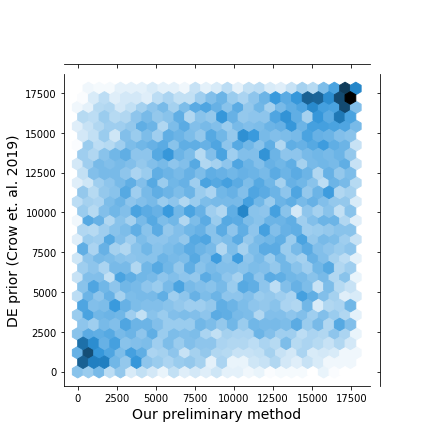

In [30]:
if compare_genes:
    # Get generic genes identified by Crow et. al.
    DE_prior_file = params['reference_gene_file']
    ref_gene_col = params['reference_gene_name_col']
    ref_rank_col = params['reference_rank_col']
    
    # Merge our ranking and reference ranking
    shared_gene_rank_df = process.merge_ranks_to_compare(
        summary_gene_ranks,
        DE_prior_file,
        ref_gene_col,
        ref_rank_col)
    
    if max(shared_gene_rank_df["Rank (simulated)"]) != max(shared_gene_rank_df[ref_rank_col]):
        shared_gene_rank_scaled_df = process.scale_reference_ranking(shared_gene_rank_df, ref_rank_col)
        
    # Get correlation
    r, p, ci_high, ci_low = calc.spearman_ci(0.95,
                                             shared_gene_rank_scaled_df,
                                             1000)
    print(r, p, ci_high, ci_low)
    #assert(np.all(np.isclose([r,p],
    #                         [0.2397233887765045, 3.960267987659121e-223]
    #                        )
    #             )
    #      )
    
    # Plot our ranking vs published ranking
    fig_file = os.path.join(
        local_dir, 
        "gene_ranking_"+col_to_rank+".svg")

    fig = sns.jointplot(data=shared_gene_rank_scaled_df,
                        x='Rank (simulated)',
                        y=ref_rank_col,
                        kind='hex',
                        marginal_kws={'color':'white'})
    fig.set_axis_labels("Our preliminary method", "DE prior (Crow et. al. 2019)", fontsize=14)

    fig.savefig(fig_file,
                format='svg',
                bbox_inches="tight",
                transparent=True,
                pad_inches=0,
                dpi=300,)

**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate the some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.

### Compare pathway ranking